In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import linear_regression_game
import costsfunctions as cost
import numbers

# Definition of polynomial regression game and optimal design

In [9]:
class Poly_game:
    def __init__(self, x_list, degree, probas, exponents):
        """
        Initialize a game with polynomial regression
        - x_list = features of players.
        - degree the degree of the polynomial regression
        - proba = probability of each feature
        - exponents = double or array of double (= exponent of monomial costs)
        By default, we add non-strategic players that span the whole state. 
        """
        self.number_of_features = len(x_list)
        self.number_of_players = len(exponents)
        self.dimension = degree + 1
        assert len(x_list) == len(probas), "Error: 'x_list' and 'proba' should be of same length"
        X = [[x**i for i in range(degree + 1)] for x in x_list]
        for x in X:
            assert len(x) == self.dimension, "Error: some features have a wrong dimension"
        self.X = np.array(X)
        self.probas = np.array(probas)
        self.exponents = exponents

    def precision_game(self, scalarization):
        costs = [cost.monomial_cost for i in range(self.number_of_players)]
        precisions = linear_regression_game.covariance_equilibrium(self.X, self.probas,
                                              scalarization, costs, self.exponents)
        return precisions.reshape((self.number_of_players, self.number_of_features))
    
    def scalarization_value(self, precisions, scalarization):
        precisions = precisions.flatten()
        var = linear_regression_game.var(precisions, self.X, self.probas)
        return scalarization(var, self.X, self.probas)
    
class Design_prob:
    def __init__(self, x_list, degree, probas):
        """
        Initialize an optimal design problem
        - x_list = features of players.
        - degree the degree of the polynomial regression
        - proba = probability of each feature (relevant for the scalarization)
        """
        self.number_of_features = len(x_list)
        self.dimension = degree + 1
        assert len(x_list) == len(probas), "Error: 'x_list' and 'proba' should be of same length"
        X = [[x**i for i in range(degree + 1)] for x in x_list]
        for x in X:
            assert len(x) == self.dimension, "Error: some features have a wrong dimension"
        self.X = np.array(X)
        self.probas = np.array(probas)
    
    def optimal_design(self, scalarization):
        design = linear_regression_game.optimal_design(self.X, self.probas, scalarization)
        return design

# Plot functions

In [10]:
n_players = 1
nb_features = 21
middle = nb_features//2
x_list = np.array([i-middle for i in range(nb_features)])

def unif(xmin=-1000, xmax=1000, epsilon=1e-6):
    p = (x_list >= xmin) * (x_list <= xmax) + epsilon
    return p/sum(p)

def bell(center, epsilon=1e-4):
    """
    The + epsilon is to avoid probabilities too close to 0
    A proba too close to 0 leads to an imprecise computation of the equilibrium at those points
    """
    p = np.exp(-.08*(x_list-center)**2) + epsilon
    return p / sum(p)

def double_bell(center1, center2, epsilon=1e-4):
    """
    The + epsilon is to avoid probabilities too close to 0
    A proba too close to 0 leads to an imprecise computation of the equilibrium at those points
    """
    p1 = np.exp(-.08*(x_list-center1)**2)
    p2 = np.exp(-.08*(x_list-center2)**2)
    p = p1+0.3*p2+epsilon
    return p/sum(p)

            
def plot_equilibrium_and_optimal(distrib, exponents=[2], deg=4, costfunction=cost.trace_wihout1stcoordinate, multiplyproba=False, name="../figures/tempfig"):
    """
    Plots the equilibrium strategies and the optimal design for polynomial regression given:
    - distrib the probability distribution over vectors
    - exponents the exponents of the privacy costs of players
    - deg_min and deg_max the degrees of the polynomial regression
    - costfunction the scalarization
    - multiplyproba a boolean set to true to represent precision times probability of presence and false otherwise
    """
    fig=plt.figure()
    fig.set_size_inches((3.5,2.5))
    design_prob = Design_prob(x_list, deg, distrib)
    design = design_prob.optimal_design(costfunction)
    plt.bar(x_list, design)
    plt.xlabel(x_label)
    plt.ylabel(r'$\nu^*([1,x\dots,x^{d-1}])$')
    plt.savefig('{}{}.pdf'.format(name,'opt'),bbox_inches='tight')

    n = 10
    
    for i, exponent in enumerate(exponents):
        fig=plt.figure()
        fig.set_size_inches((3.5,2.5))
        g = Poly_game(x_list, deg, distrib, [exponent])
        precision = g.precision_game(costfunction)[0]*n**((exponent-1)/(exponent+1))
        if(multiplyproba):
            precision = precision*distrib
        plt.bar(x_list,precision, label='Equilibrium strategy')
        #plt.legend()
        plt.xlabel(x_label)
        if(multiplyproba):
            plt.ylabel(r'$\nu_{\mathbf{\lambda}^*}([1,x\dots,x^{d-1}])$')
        else:
            plt.ylabel(r'$\sum_i\lambda_i^*([1,x\dots,x^{d-1}])$')
        plt.savefig('{}{}.pdf'.format(name,int(100*exponent)),bbox_inches='tight')

# Plot parameters

In [11]:
x_label = r'$x$'

# Precision and optimal design for figure 1

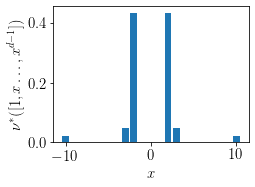

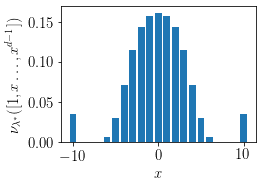

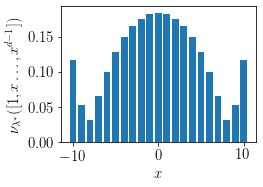

In [12]:
plot_equilibrium_and_optimal(unif(), exponents=[1.01, 1.2, 3], deg=3, name="../figures_paper/unif", costfunction = cost.trace_scalarization, multiplyproba=True)

 # Figure 2

In [13]:
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams.update({'font.size': 15})

def plot_estimation(pq_list, minplay, maxplay):
    fig = plt.figure()
    fig.set_size_inches((4,3))
    n_range = np.arange(minplay, maxplay + 1)
    for i in range(len(pq_list)):
        p = pq_list[i][0]
        q = pq_list[i][1]
        estim = n_range**(-q*(p - 1)/(p + q))
        plt.plot(n_range, estim, label=r'$p = {}$, $q = {}$'.format(p, q))
    plt.xlabel(r"$n$", fontsize=15)
    plt.ylabel(r'$n^{-q\frac{p - 1}{p + q}}$', fontsize=15)
    plt.legend(fontsize=15, loc='right')
    plt.tight_layout()
    plt.savefig("../figures_paper/place_1.pdf")
    
def plot_ratio(pq_list, minplay, maxplay):
    fig = plt.figure()
    fig.set_size_inches((4,3))
    n_range = np.arange(minplay, maxplay + 1)
    for i in range(len(pq_list)):
        p = pq_list[i][0]
        q = pq_list[i][1]
        estim = n_range**(q*(q + 1)/(p + q))
        plt.plot(n_range, estim, label=r'$p = {}$, $q = {}$'.format(p, q))
    plt.xlabel(r'$n$', fontsize=15)
    plt.ylabel(r'$n^{\frac{q(q + 1)}{p + q}}$', fontsize=15)
    plt.tight_layout()
    plt.savefig("../figures_paper/place_2.pdf")

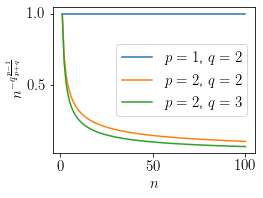

In [14]:
plot_estimation([[1, 2], [2, 2], [2, 3]], 1, 100)

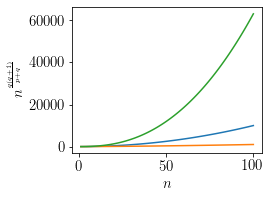

In [15]:
plot_ratio([[1, 2], [2, 2], [2, 3]], 1, 100)

# Distributions for Figure 3

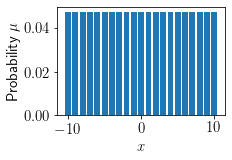

In [16]:
fig = plt.figure()
fig.set_size_inches((3,2))
plt.bar(x_list, unif())
plt.ylabel(r"Probability $\mu$")
plt.xlabel(x_label)
plt.savefig("../figures_paper/unif_distrib.pdf", bbox_inches='tight')

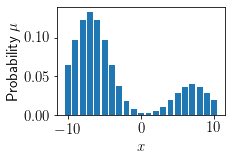

In [17]:
fig = plt.figure()
fig.set_size_inches((3,2))
plt.bar(x_list, double_bell(-7, 7))
plt.ylabel(r"Probability $\mu$")
plt.xlabel(x_label)
plt.savefig("../figures_paper/double_distrib.pdf", bbox_inches='tight')

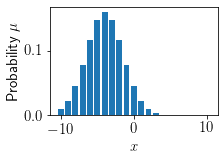

In [18]:
fig = plt.figure()
fig.set_size_inches((3,2))
plt.bar(x_list, bell(-4))
plt.ylabel(r"Probability $\mu$")
plt.xlabel(x_label)
plt.savefig("../figures_paper/simple_distrib.pdf", bbox_inches='tight')

# Precision and optimal design for figure 3

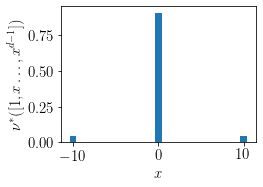

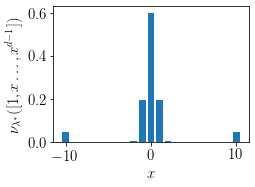

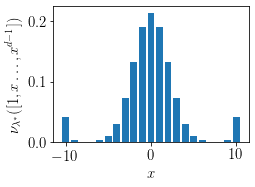

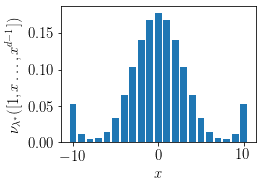

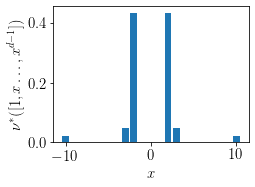

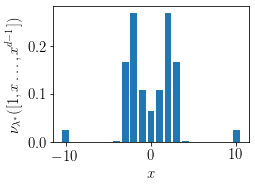

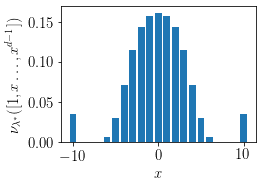

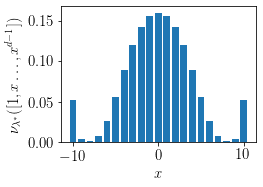

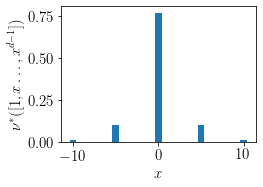

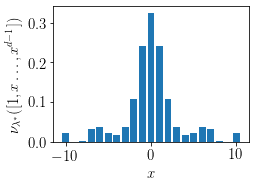

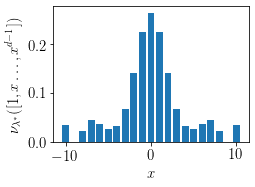

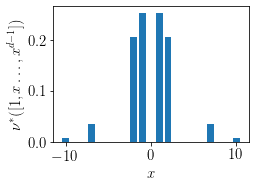

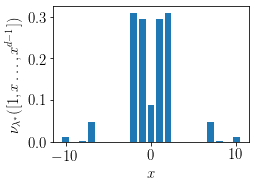

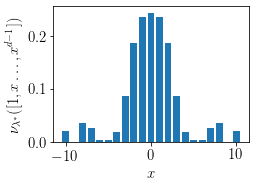

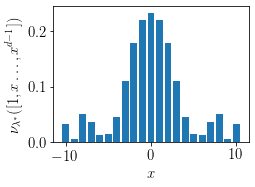

In [19]:
for deg in [2, 3, 4, 5]:
    plot_equilibrium_and_optimal(unif(), exponents=[1.01, 1.2, 1.5], deg=deg, name="../figures_paper/unif_deg{}_".format(deg+1), costfunction = cost.trace_scalarization, multiplyproba=True)         
    

# Figure 4

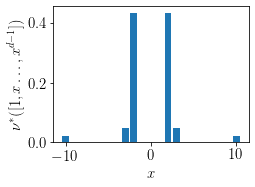

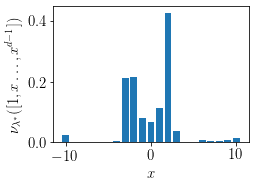

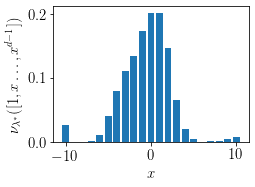

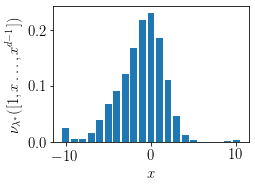

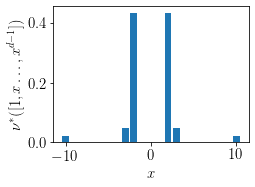

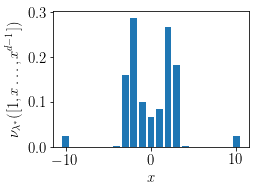

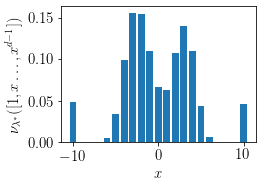

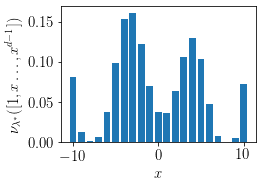

In [20]:
deg=3
plot_equilibrium_and_optimal(bell(-4), exponents=[1.01, 1.2, 1.5], deg=deg, name="../figures_paper/simple_deg{}_".format(deg+1), costfunction = cost.trace_scalarization, multiplyproba=True)
plot_equilibrium_and_optimal(double_bell(-7,7), exponents=[1.01, 1.2, 1.5], deg=deg, name="../figures_paper/double_deg{}_".format(deg+1), costfunction = cost.trace_scalarization, multiplyproba=True)


# Figure 5

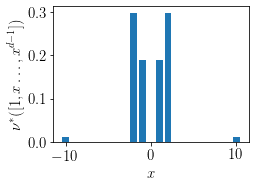

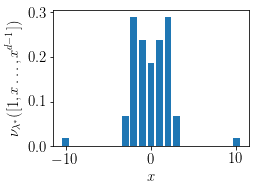

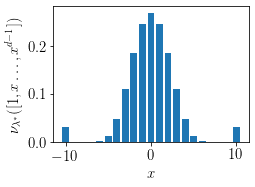

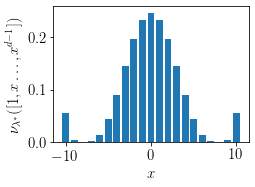

In [21]:
plot_equilibrium_and_optimal(unif(), exponents=[1.01, 1.2, 1.5], deg=3, name="../figures_paper/unif_frob_", costfunction = cost.square_frobenius, multiplyproba=True)